In [1]:
%config IPCompleter.use_jedi = False
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 99%; }
    div#menubar-container     { width: 99%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [5]:
import os
import glob
import pathlib
import multiprocessing as mp
from PIL import Image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
import shutil

In [6]:
%matplotlib inline

### Split into train/val

In [8]:
list_images = sorted(glob.glob("/data/Documents/Pastai/inputs/annotations/pastai_annotated_data/jpg_converted_images/*.jpg"))
list_labels = sorted(glob.glob("/data/Documents/Pastai/inputs/annotations/pastai_annotated_data/FINAL_ANNOTATIONS_task_bboxes-2021_05_25_21_30_27-yolo 1.1/obj_train_data/*.txt"))
assert len(list_images) == len(list_labels)
print(len(list_labels))

4688


In [9]:
imgs_train, imgs_val, labels_train, labels_val = train_test_split(list_images, list_labels, test_size=0.15, random_state=123)
len(imgs_train), len(labels_train), len(imgs_val), len(labels_val)

(3984, 3984, 704, 704)

In [10]:
os.makedirs("../inputs/annotations/pastai_annotated_data/images/train", exist_ok=True)
os.makedirs("../inputs/annotations/pastai_annotated_data/images/val", exist_ok=True)
os.makedirs("../inputs/annotations/pastai_annotated_data/labels/train", exist_ok=True)
os.makedirs("../inputs/annotations/pastai_annotated_data/labels/val", exist_ok=True)

In [11]:
%%time

def move_file(src, dst): shutil.move(src, dst)
def copy_file(src, dst): shutil.copy(src, dst)

# move train images
list_args = [(p, "../inputs/annotations/pastai_annotated_data/images/train") for p in imgs_train]
with mp.Pool() as pool:
    pool.starmap(move_file, tqdm(list_args))
    
# copy train labels
list_args = [(p, "../inputs/annotations/pastai_annotated_data/labels/train") for p in labels_train]
with mp.Pool() as pool:
    pool.starmap(move_file, tqdm(list_args))


# move val images
list_args = [(p, "../inputs/annotations/pastai_annotated_data/images/val") for p in imgs_val]
with mp.Pool() as pool:
    pool.starmap(move_file, tqdm(list_args))
    
# copy val labels
list_args = [(p, "../inputs/annotations/pastai_annotated_data/labels/val") for p in labels_val]
with mp.Pool() as pool:
    pool.starmap(move_file, tqdm(list_args))

100%|██████████| 704/704 [00:00<00:00, 126257.75it/s]

CPU times: user 86.8 ms, sys: 157 ms, total: 244 ms
Wall time: 395 ms


In [13]:
# !rm -rf "/data/Documents/Pastai/inputs/annotations/pastai_annotated_data/jpg_converted_images/"

### Sample visualization

In [24]:
imgs_train = sorted(glob.glob("../inputs/annotations/pastai_annotated_data/images/train/*.jpg"))
labels_train = sorted(glob.glob("../inputs/annotations/pastai_annotated_data/labels/train/*.txt"))
imgs_val = sorted(glob.glob("../inputs/annotations/pastai_annotated_data/images/val/*.jpg"))
labels_val = sorted(glob.glob("../inputs/annotations/pastai_annotated_data/labels/val/*.txt"))

len(imgs_train), len(labels_train), len(imgs_val), len(labels_val)

(3984, 3984, 704, 704)

In [25]:
def unnormalize_coords(h, w, coords):
    h1, w1 = h*coords[-1], w*coords[-2]
    x_center, y_center = w*coords[1], h*coords[2]
    x_min, y_min = int(x_center - w1/2), int(y_center - h1/2)
    x_max, y_max = int(x_center + w1/2), int(y_center + h1/2)
    return x_min, y_min, x_max, y_max


def annotate_image(path_img, path_label):
    img = cv2.imread(path_img)
    h, w = img.shape[:2]
    with open(path_label) as f:
        labels = [[float(num) for num in item.split()] for item in f.readlines()]
    for coord in labels:
        x_min, y_min, x_max, y_max = unnormalize_coords(h, w, coord)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max),
                      color=(0, 255, 0), thickness=5)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def viz_annotated(list_images, list_labels):
    rnd_idx = random.sample(range(len(list_labels)), 9)
    list_annotated = [annotate_image(list_images[idx], list_labels[idx]) for idx in rnd_idx]
    fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 15))
    axes = axes.ravel()
    for i, im in enumerate(list_annotated):
        axes[i].imshow(im)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

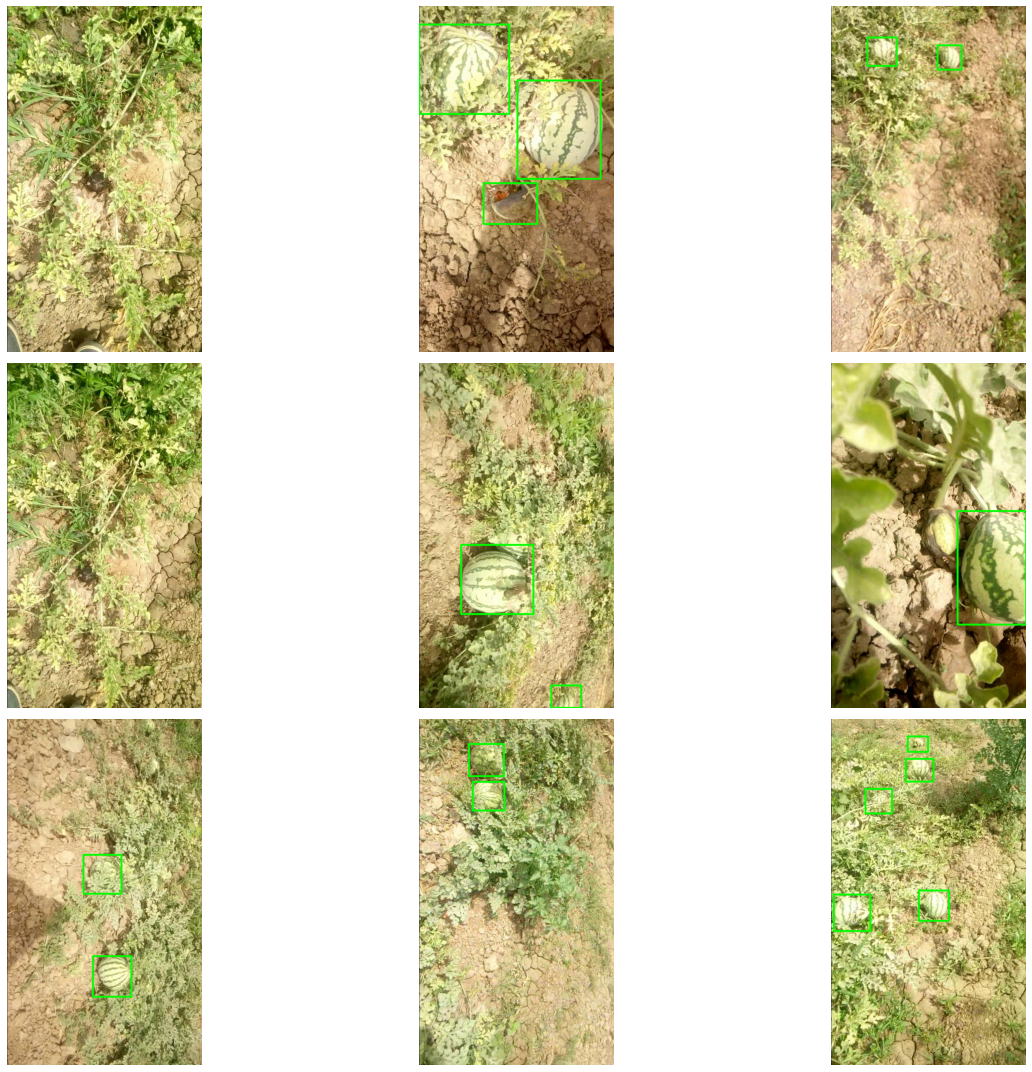

In [26]:
viz_annotated(imgs_train, labels_train)

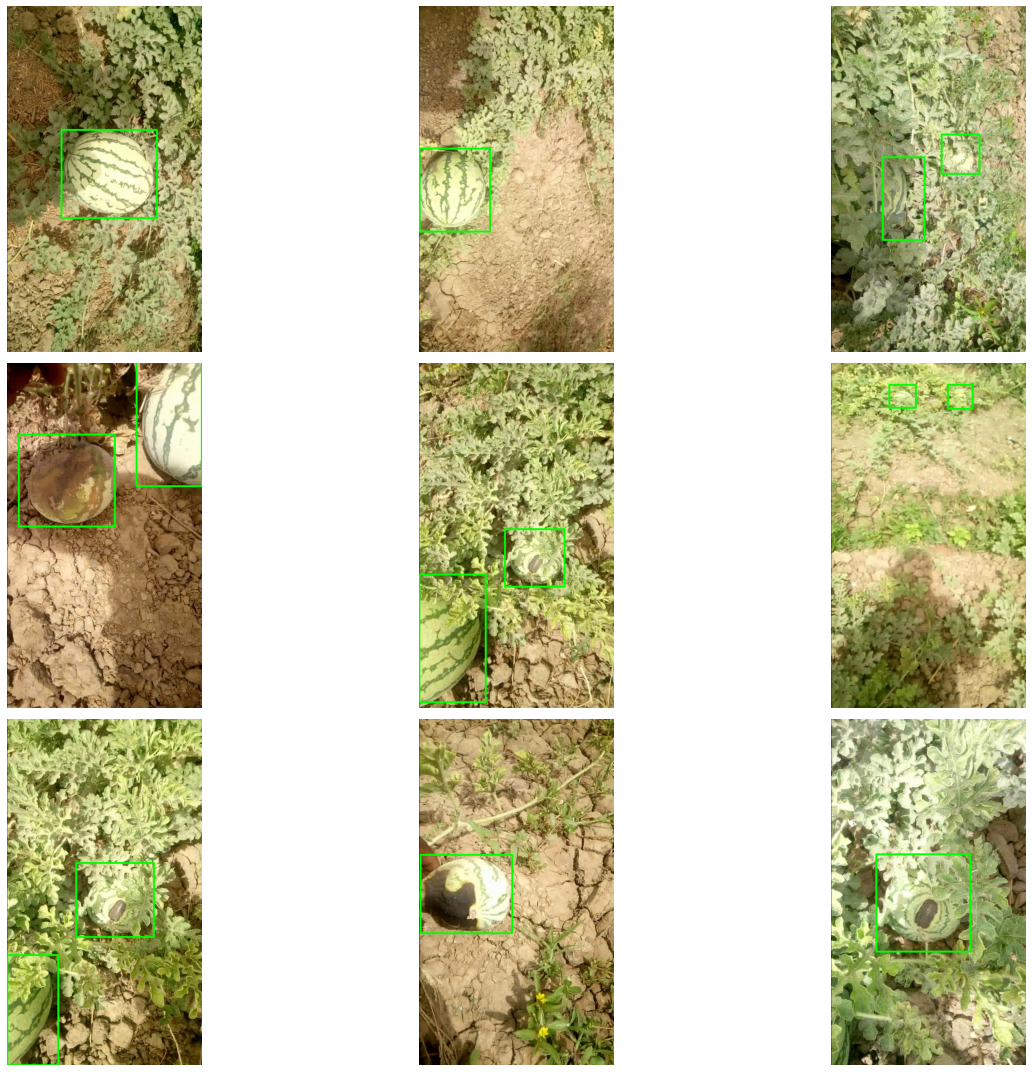

In [27]:
viz_annotated(imgs_val, labels_val)

In [50]:
32+16

48

### Create small version dataset for pipeline testing

In [29]:
os.makedirs("../inputs/annotations/pastai_annotated_data_small/images/train/", exist_ok=True)
os.makedirs("../inputs/annotations/pastai_annotated_data_small/images/val/", exist_ok=True)
os.makedirs("../inputs/annotations/pastai_annotated_data_small/labels/train/", exist_ok=True)
os.makedirs("../inputs/annotations/pastai_annotated_data_small/labels/val/", exist_ok=True)

In [30]:
imgs_train = sorted(glob.glob("../inputs/annotations/pastai_annotated_data/images/train/*.jpg"))
labels_train = sorted(glob.glob("../inputs/annotations/pastai_annotated_data/labels/train/*.txt"))
imgs_train

# copy 32 samples as training small
list_args = [(p, "../inputs/annotations/pastai_annotated_data_small/images/train/") for p in imgs_train[:32]]
with mp.Pool() as pool:
    pool.starmap(copy_file, tqdm(list_args))
list_args = [(p, "../inputs/annotations/pastai_annotated_data_small/labels/train/") for p in labels_train[:32]]
with mp.Pool() as pool:
    pool.starmap(copy_file, tqdm(list_args))
    
# copy 16 samples as validation small
list_args = [(p, "../inputs/annotations/pastai_annotated_data_small/images/val/") for p in imgs_train[32:32+16]]
with mp.Pool() as pool:
    pool.starmap(copy_file, tqdm(list_args))
list_args = [(p, "../inputs/annotations/pastai_annotated_data_small/labels/val/") for p in labels_train[32:32+16]]
with mp.Pool() as pool:
    pool.starmap(copy_file, tqdm(list_args))

100%|██████████| 16/16 [00:00<00:00, 21324.71it/s]


In [31]:
!cp "../inputs/annotations/pastai_annotated_data/obj.names" "../inputs/annotations/pastai_annotated_data_small/"

In [35]:
tmp = Image.open("../inputs/annotations/pastai_annotated_data_small/images/train/frame_000007.jpg")
tmp.size

(720, 1280)

In [49]:
Image.open("../output/train/small/run/exp2/exp/frame_000041.jpg").size

(720, 1280)